# 🌴 Sistem Rekomendasi Destinasi Wisata Indonesia

Notebook ini bertujuan untuk membangun sistem rekomendasi destinasi wisata di Indonesia dengan mencoba dua pendekatan yang berbeda:
- **Content-Based Filtering**: merekomendasikan tempat wisata berdasarkan kemiripan konten/atribut
- **Collaborative Filtering**: merekomendasikan berdasarkan preferensi pengguna serupa

Pengembangan sistem ini penting karena:
1. Indonesia memiliki kekayaan wisata yang sangat berkualitas namun belum banyak mendapatkan popularitas.
2. Pengunjung sering kesulitan menemukan destinasi yang sesuai preferensi
3. Potensi peningkatan pariwisata melalui personalisasi rekomendasi

# Import Library

Pada bagian ini dilakukan import library yang diperlukan untuk pengembangan sistem rekomendasi Conten Based Filtering dan Collaborative Filtering

In [ ]:
# Data Preparation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Content-Based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Collaborative Filtering
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Load Data

Pada tahap awal ini, kita melakukan pemuatan dataset yang menjadi fondasi sistem rekomendasi wisata. Data diperoleh dari repository GitHub pribadi penulis yang berisi dataset dalam bentuk csv. Dadtaset ini berisi informasi tentang tempat wisata di Indonesia beserta rating dari pengguna. Sumber dataset yang digunakan berasal dari dataset [Kaggle](https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination) dataset pariwisata Indonesia

In [ ]:
rating = pd.read_csv('https://raw.githubusercontent.com/syafiqirz/Tourist-Attraction-Recommendation-System/refs/heads/main/tourism_rating.csv')
tourism = pd.read_csv('https://raw.githubusercontent.com/syafiqirz/Tourist-Attraction-Recommendation-System/refs/heads/main/tourism_with_id.csv')
user = pd.read_csv('https://raw.githubusercontent.com/syafiqirz/Tourist-Attraction-Recommendation-System/refs/heads/main/user.csv')
print('Jumlah data rating yang ada', len(rating))
print('Jumlah data user yang ada', len(user))
print('Jumlah data tempat wisata yang ada', len(tourism))

Jumlah data rating yang ada 10000
Jumlah data user yang ada 300
Jumlah data tempat wisata yang ada 437


Terdapat tiga dataset utama yang dimuat:

- **Data Rating** (tourism_rating.csv) yang mencatat penilaian pengguna terhadap berbagai destinasi wisata

- **Data Destinasi Wisata** (tourism_with_id.csv) berisi informasi detail setiap tempat wisata seperti nama, lokasi, kategori, dan atribut lainnya.

- **Data Pengguna** (user.csv) yang berisi data pengguna sistem, seperti nama, umur, dan id pengguna.

Setelah memuat data, kita melakukan pemeriksaan awal terhadap volume data yang tersedia. Hasilnya menunjukkan bahwa dataset ini memiliki 10.000 interaksi rating, 300 pengguna terdaftar, dan 437 destinasi wisata berbeda yang tersebar di berbagai lokasi di Indonesia.

Angka-angka ini memberikan gambaran awal tentang skala sistem rekomendasi yang sedang kita bangun. Dengan rasio pengguna terhadap destinasi wisata yang seimbang, sistem ini memiliki potensi untuk memberikan rekomendasi yang cukup beragam.



# Exploratory Data Analysis (EDA)

Pada tahap EDA ini, dilakukan eksplorasi awal terhadap data untuk memahami jumlah data, struktur data, kondisi data, dan karakteristik masing-masing variabel. EDA membantu dalam mengidentifikasi potensi masalah seperti data kosong, data tidak valid, atau distribusi yang tidak seimbang yang dapat mempengaruhi performa model. Proses ini merupakan langkah penting sebelum dilakukan pemodelan machine learning, karena kualitas input data akan sangat menentukan kualitas prediksi yang dihasilkan.

## User

### Profil data User


In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


In [ ]:
user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


Dataset ini berisi profil **300 pengguna** sistem rekomendasi dengan **3 atribut** utama:

- `User_Id`: Nomor identifikasi unik setiap pengguna (integer)

- `Location`: Kota dan provinsi domisili pengguna (string)

- `Age`: Usia pengguna dalam tahun (integer)

**Struktur Data**:

- Terdapat 300 pengguna unik (diverifikasi dari User_Id)

- Data lengkap tanpa nilai kosong di semua kolom

### Distribusi Geografis

In [ ]:
jumlah_user = user['User_Id'].nunique()
jumlah_lokasi = user['Location'].nunique()
print(f"Terdapat {jumlah_user} user yang berasal dari {jumlah_lokasi} lokasi berbeda: \n Lokasi:", user['Location'].unique())

Terdapat 300 user yang berasal dari 28 lokasi berbeda: 
 Lokasi: ['Semarang, Jawa Tengah' 'Bekasi, Jawa Barat' 'Cirebon, Jawa Barat'
 'Lampung, Sumatera Selatan' 'Jakarta Utara, DKI Jakarta'
 'Jakarta Selatan, DKI Jakarta' 'Bandung, Jawa Barat'
 'Surabaya, Jawa Timur' 'Yogyakarta, DIY' 'Bogor, Jawa Barat'
 'Depok, Jawa Barat' 'Jakarta Pusat, DKI Jakarta'
 'Jakarta Timur, DKI Jakarta' 'Subang, Jawa Barat'
 'Jakarta Barat, DKI Jakarta' 'Palembang, Sumatera Selatan'
 'Sragen, Jawa Tengah' 'Ponorogo, Jawa Timur' 'Klaten, Jawa Tengah'
 'Solo, Jawa Tengah' 'Tanggerang, Banten' 'Serang, Banten'
 'Cilacap, Jawa Tengah' 'Kota Gede, DIY' 'Karawang, Jawa Barat'
 'Purwakarat, Jawa Barat' 'Nganjuk, Jawa Timur' 'Madura, Jawa Timur']


Pengguna berasal dari **28 wilayah berbeda**, dengan dominasi dari:

- **Jawa Barat** (Bekasi, Cirebon, Bandung, Bogor, Depok, Subang, Karawang, Purwakarta)

- **DKI Jakarta** (semua wilayah administratif: Jakarta Utara, Selatan, Pusat, Timur, Barat)

- **Jawa Tengah** (Semarang, Sragen, Klaten, Solo, Cilacap)

- Wilayah lain mencakup Yogyakarta, Banten, Sumatera Selatan, dan Jawa Timur

### Analisis Univariat

#### Location

Visualisasi di bawah adalah diagram batang (bar chart) yang menggambarkan distribusi frekuensi pengguna (user) berdasarkan lokasi.
Dari total 300 pengguna yang teridentifikasi berasal dari 28 lokasi berbeda, dapat dilihat bahwa:

- **Konsentrasi Pengguna Tertinggi**: Lokasi dengan jumlah pengguna terbanyak adalah Bekasi, Jawa Barat, yang mencakup 13.0% dari total pengguna (sekitar 39 pengguna).
- **Lokasi Dominan Lainnya**: Menyusul di belakang Bekasi adalah Semarang, Jawa Tengah (7.3%), serta Lampung, Sumatera Selatan dan Yogyakarta, DIY (keduanya 6.7%).
- **Distribusi Tidak Merata**: Sebagian besar lokasi lainnya memiliki persentase pengguna yang jauh lebih kecil (banyak di antaranya di bawah 5%), menunjukkan adanya konsentrasi pengguna yang cukup signifikan di beberapa lokasi utama dibandingkan dengan sebaran yang merata di semua lokasi.


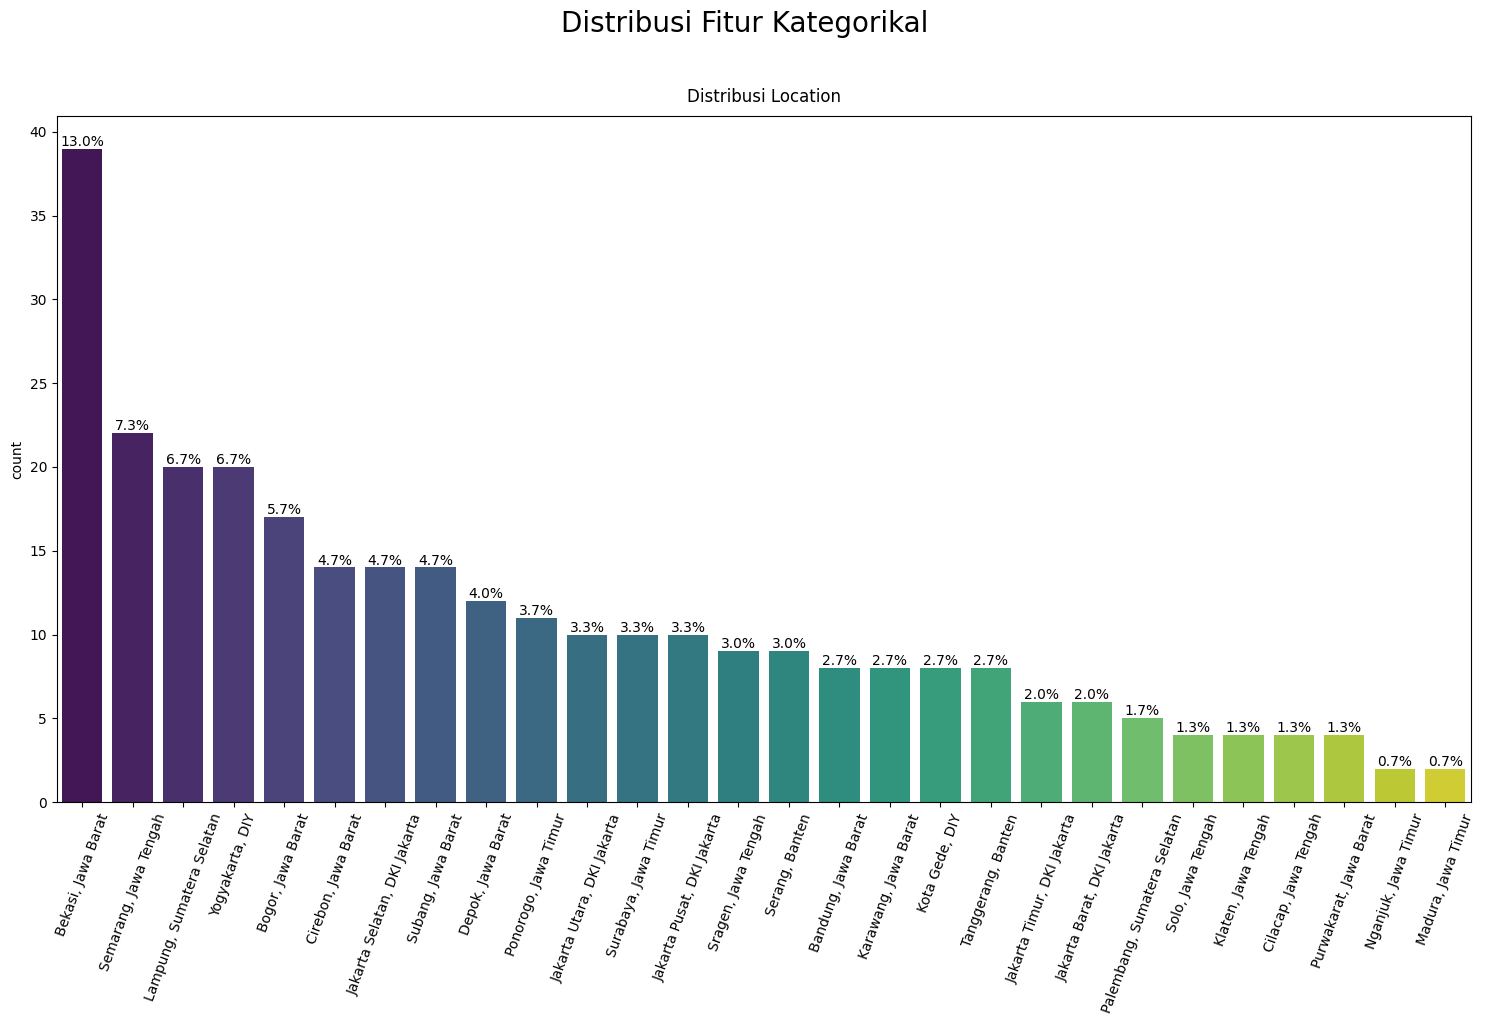

In [ ]:
categorical_columns = ['Location']
df = user.copy()
plt.figure(figsize=(15, 10))
plt.suptitle('Distribusi Fitur Kategorikal', y=1.02, fontsize=20)

ax = sns.countplot(data=df, x=categorical_columns[0], palette='viridis',
                   order=df[categorical_columns[0]].value_counts().index)

total = len(df)
for p in ax.patches:
    ax.annotate(f'{100 * p.get_height()/total:.1f}%',
               (p.get_x() + p.get_width()/2., p.get_height()),
               ha='center', va='center', xytext=(0, 5),
               textcoords='offset points')

plt.title(f'Distribusi {categorical_columns[0]}', pad=10)
plt.xticks(rotation=70)
plt.xlabel('')
plt.tight_layout()
plt.show()

#### Age
Visualisasi di bawah adalah histogram yang menampilkan distribusi frekuensi variabel 'Age' (Usia) dari dataset. Beberapa poin interpretasi utama adalah:

- **Rentang Usia**: Sebagian besar data usia terkonsentrasi antara akhir belasan tahun (sekitar 18 tahun) hingga sekitar 40 tahun.
- **Bentuk Distribusi**:
Kedekatan nilai mean dan median (28.7 dan 29.0) menunjukkan bahwa distribusi usia relatif simetris, dengan hanya sedikit kecenderungan ke kiri (skewness negatif minor), di mana mean sedikit lebih kecil dari median.
- Puncak frekuensi tertinggi (modus) tampak berada di sekitar usia 30 tahun. Terdapat juga beberapa puncak frekuensi lain yang lebih kecil, mengindikasikan variasi dalam kelompok usia.

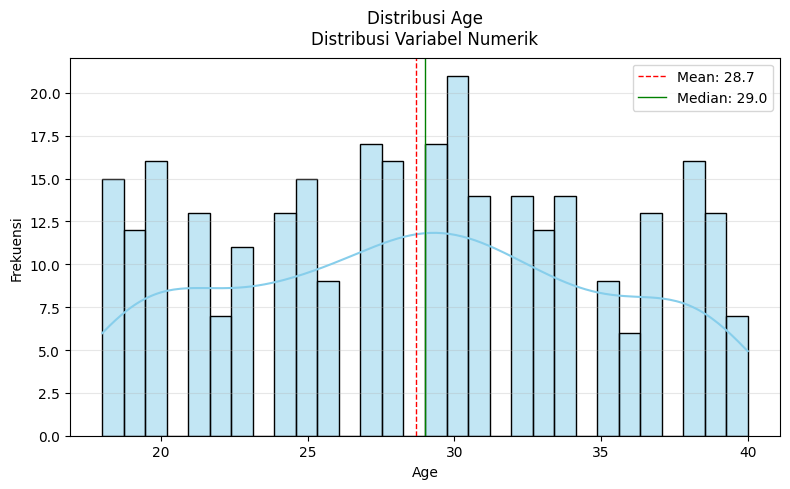

In [ ]:
numerical_columns = ['Age']
df = user.copy()
plt.figure(figsize=(8, 5))

col = numerical_columns[0]
ax = sns.histplot(data=df, x=col, kde=True, bins=30, color='skyblue')

mean_val = df[col].mean()
median_val = df[col].median()
plt.axvline(mean_val, color='r', ls='--', lw=1, label=f'Mean: {mean_val:.1f}')
plt.axvline(median_val, color='g', lw=1, label=f'Median: {median_val:.1f}')

plt.title(f'Distribusi {col}\nDistribusi Variabel Numerik', pad=10)
plt.xlabel(col)
plt.ylabel('Frekuensi')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Tourism

### Profil Data Tourism

In [ ]:
tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [ ]:
tourism.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


Melalui pemeriksaan struktur data menggunakan tourism.info(), kita mendapatkan gambaran komprehensif tentang dataset destinasi wisata yang digunakan. Dataset ini terdiri dari 437 entri destinasi wisata dengan 13 kolom atribut yang mencakup berbagai aspek penting.

**Beberapa temuan kunci dari struktur data ini:**

1. **Kelengkapan Data:** Sebagian besar kolom seperti nama tempat, deskripsi, kategori, dan lokasi memiliki data yang lengkap (437 non-null), menunjukkan kualitas data yang baik untuk analisis utama. Namun, kolom `Time_Minutes` hanya terisi 205 entri (47% dari total data) dan sisa nilainya sebesar 232 baris (53% dari total data) berisi null, yang mungkin memerlukan penanganan khusus jika ingin digunakan

2. **Kolom Redundan:** Terdapat kolom `Unnamed: 11` yang kosong dan `Unnamed: 12` yang terisi tetapi tanpa deskripsi jelas, yang kemungkinan merupakan artefak dari proses ekstraksi data dan perlu dievaluasi lebih lanjut.

3. **Tipe Data:** Dataset ini mengandung campuran tipe data numerik (`float64`, `int64`) untuk atribut kuantitatif seperti harga dan rating, serta tipe objek untuk data teks dan kategorikal.

**Berikut adalah deskripsi untuk tiap fitur `tourism`:**

- `Place_Id`: Kode unik identifikasi tempat wisata (integer)

- `Place_Name`: Nama resmi destinasi wisata (string)

- `Description`: Penjelasan detail tentang tempat wisata (string)

- `Category`: Jenis wisata (string)

- `City`: Lokasi kota tempat wisata berada (string)

- `Price`: Biaya masuk dalam Rupiah (integer)

- `Rating`: Skor popularitas tempat (float 1-5)

- `Time_Minutes`: Perkiraan waktu kunjungan dalam menit (float)

- `Coordinate/Lat/Long`: Informasi geospasial lokasi

### Analisis Univariat

#### Variabel Kategorikal (`Category`dan `City`)

Visualisasi di bawah menampilkan dua diagram batang yang menunjukkan distribusi frekuensi untuk fitur kategorikal `Category` dan `City`.

**Distribusi Category**
- Diagram batang di sebelah kiri menggambarkan distribusi kategori tempat wisata.
- Taman Hiburan merupakan kategori paling populer dengan 30.9% dari total data.
Diikuti oleh Budaya (26.8%) dan Cagar Alam (24.3%).
- Kategori lain seperti Bahari, Tempat Ibadah, dan Pusat Perbelanjaan memiliki persentase yang lebih kecil.

**Distribusi City**
- Diagram batang di sebelah kanan menunjukkan distribusi kota tempat wisata.
- Yogyakarta adalah kota dengan frekuensi tertinggi, mencakup 28.8% dari data.
Bandung berada di posisi kedua dengan 28.4%.
- Jakarta (19.2%), Semarang (13.0%), dan Surabaya (10.5%) melengkapi lima besar kota dengan frekuensi tertinggi.

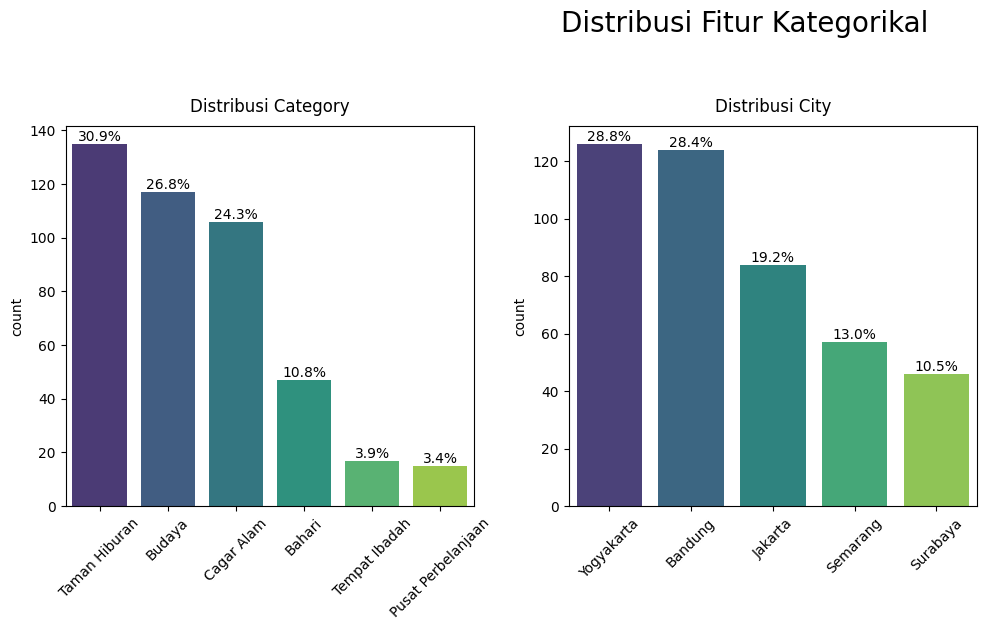

In [ ]:
categorical_columns = ['Category', 'City']
df = tourism.copy()

plt.figure(figsize=(15, 15))
plt.suptitle('Distribusi Fitur Kategorikal', y=1.02, fontsize=20)
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    ax = sns.countplot(data=df, x=col, palette='viridis',
                      order=df[col].value_counts().index)

    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height()/total:.1f}%'
        ax.annotate(percentage,
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 5),
                   textcoords='offset points')

    plt.title(f'Distribusi {col}', pad=10)
    plt.xticks(rotation=45)
    plt.xlabel('')

plt.tight_layout()
plt.show()

#### Variabel Numerikal (`Price`, `Rating`, dan `Time_Minutes`)
Visualisasi di bawah menampilkan tiga histogram yang menggambarkan distribusi frekuensi untuk variabel numerik: `Price`, `Rating`, dan `Time_Minutes`.

**Distribusi Price**
- Grafik ini menunjukkan distribusi harga. Terlihat bahwa distribusinya sangat condong ke kanan (positively skewed).
- Sebagian besar data harga terkonsentrasi pada nilai yang rendah, dengan beberapa nilai harga yang sangat tinggi (outlier) menarik mean (rata-rata) ke nilai 24652.2, yang jauh lebih besar dari median (nilai tengah) sebesar 5000.0. Ini khas untuk distribusi yang condong ke kanan.

**Distribusi Rating**
- Distribusi rating tampak sedikit condong ke kiri (negatively skewed).
- Sebagian besar rating terkonsentrasi pada nilai yang tinggi (sekitar 4.2 hingga 4.8).
- Mean (4.4) sedikit lebih kecil dari median (4.5), yang mengindikasikan adanya beberapa rating yang lebih rendah yang menarik rata-rata ke kiri.

**Distribusi Time_Minutes**
- Distribusi durasi waktu dalam menit juga menunjukkan kecenderungan condong ke kanan (positively skewed).
- Frekuensi tertinggi berada pada durasi waktu yang relatif singkat, dengan beberapa destinasi memiliki durasi waktu yang jauh lebih lama.
- Mean (82.6 menit) lebih besar dari median (60.0 menit), menandakan bahwa nilai-nilai durasi yang lebih panjang mempengaruhi rata-rata.

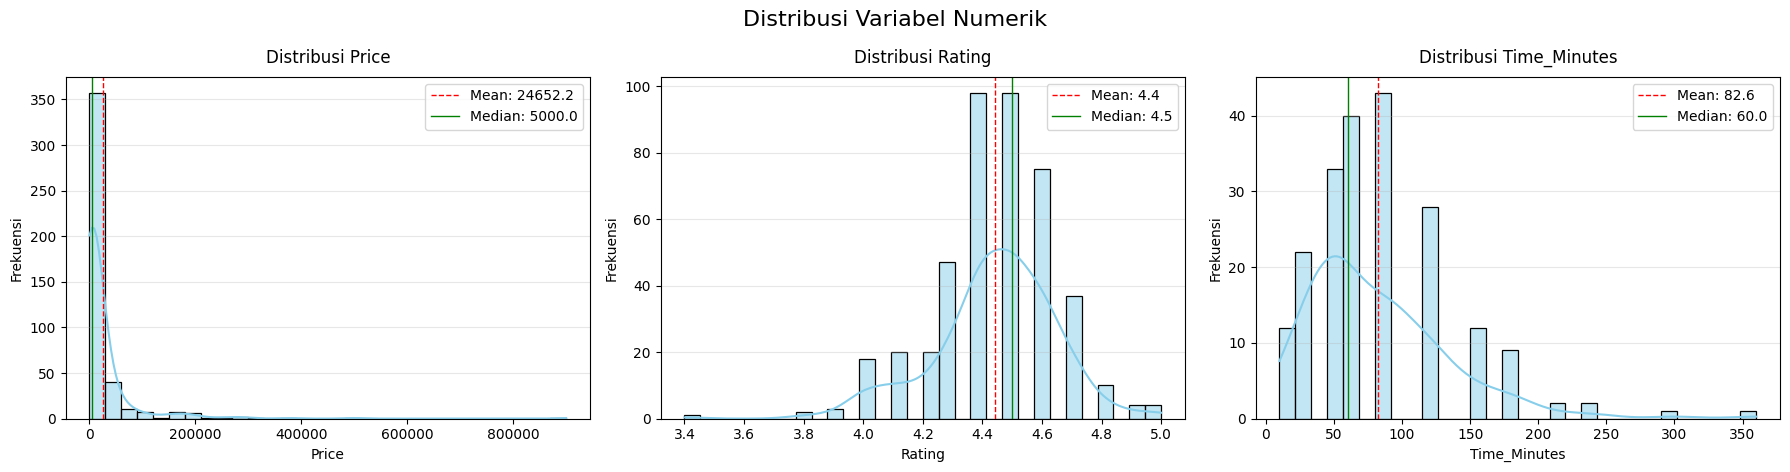

In [ ]:
numerical_columns = ['Price', 'Rating', 'Time_Minutes']
df = tourism.copy()

plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, kde=True, bins=30, color='skyblue')

    plt.title(f'Distribusi {col}', fontsize=12, pad=10)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Frekuensi', fontsize=10)
    plt.grid(axis='y', alpha=0.3)

    mean_val = df[col].mean()
    median_val = df[col].median()
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.1f}')
    plt.axvline(median_val, color='green', linestyle='-', linewidth=1, label=f'Median: {median_val:.1f}')
    plt.legend()

plt.tight_layout()
plt.suptitle('Distribusi Variabel Numerik', y=1.02, fontsize=16)
plt.show()

### Karakteristik Destinasi Wisata

In [ ]:
jumlah_tourism = tourism['Place_Id'].nunique()
jumlah_kategori = tourism['Category'].nunique()
print(f"Terdapat {jumlah_tourism} destinasi wisata dengan {jumlah_kategori} kategori berbeda: \n Kategori:", tourism['Category'].unique())

Terdapat 437 destinasi wisata dengan 6 kategori berbeda: 
 Kategori: ['Budaya' 'Taman Hiburan' 'Cagar Alam' 'Bahari' 'Pusat Perbelanjaan'
 'Tempat Ibadah']


Analisis lebih lanjut mengungkapkan keragaman dalam kategori destinasi wisata. Terdapat **437 destinasi unik** yang terbagi dalam **6 kategori utama:**

- **Budaya** - Menyajikan kekayaan warisan budaya Indonesia

- **Taman Hiburan** - Destinasi rekreasi dan taman bermain

- **Cagar Alam** - Kawasan konservasi dan wisata alam

- **Bahari** - Wisata pantai dan kelautan

- **Pusat Perbelanjaan** - Mall dan tempat belanja

- **Tempat Ibadah** - Destinasi religius dan spiritual



## Rating

### Profil Data Rating

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [ ]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


Hasil pemeriksaan menunjukkan dataset rating terdiri dari **10.000 entri** yang merekam interaksi antara pengguna dan destinasi wisata.

Struktur data mengungkapkan **tiga kolom** utama:
- `User_Id`: ID pengguna yang memberikan rating (integer 1-300)

- `Place_Id`: ID tempat wisata yang dirating (integer 1-437)
- `Place_Ratings`: Skor penilaian (integer 1-5)

Tidak terdapat nilai kosong dalam dataset ini, yang ditunjukkan oleh 10.000 entri non-null untuk setiap kolom.

In [ ]:
rating.describe()

,User_Id,Place_Id,Place_Ratings
count,10000.000000,10000.000000,10000.000000
mean,151.292700,219.416400,3.066500
std,86.137374,126.228335,1.379952
min,1.000000,1.000000,1.000000
25%,77.000000,108.750000,2.000000
50%,151.000000,220.000000,3.000000
75%,226.000000,329.000000,4.000000
max,300.000000,437.000000,5.000000


Analisis statistik deskriptif memberikan beberapa wawasan menarik:

1. **Skor rating rata-rata berada di 3.07** dengan deviasi standar 1.38, menunjukkan kecenderungan penilaian berada di sekitar nilai tengah (3) dengan variasi yang cukup signifikan.

2. Distribusi rating menunjukkan 25% data berada di bawah rating 2 dan 75% di bawah rating 4, mengindikasikan **sebagian besar pengguna memberikan penilaian antara 2-4.**

3. Nilai ekstrim menunjukkan adanya **rating terendah (1) dan tertinggi (5)**, membuktikan bahwa skala penilaian digunakan sepenuhnya.

In [ ]:
print('Jumlah UserID: ', len(rating.User_Id.unique()))
print('Jumlah PlaceID: ', len(rating.Place_Id.unique()))
print('Jumlah data rating: ', len(rating))

Jumlah UserID:  300
Jumlah PlaceID:  437
Jumlah data rating:  10000


Pemeriksaan lebih lanjut terhadap dimensi data mengungkap:

- Terdapat **300 user unik** yang memberikan rating

- Rating mencakup **437 destinasi wisata berbeda**

- Dengan **total 10.000 rating,** kita dapat menghitung kepadatan matriks rating sebagai 10.000/(300×437) ≈ **7.6%**, yang termasuk sparse namun cukup untuk sistem rekomendasi dasar.

### Analisis Univariat

#### Variabel Numerikal (`Place_Ratings`)

Grafik histogram di bawah menunjukkan distribusi frekuensi dari Place_Ratings. Dapat diamati bahwa:

- **Distribusi Multimodal**: Data memiliki beberapa puncak (modes), yang terlihat jelas pada nilai rating 1, 2, 3, 4, dan 5. Ini mengindikasikan bahwa rating-rating tersebut merupakan yang paling sering muncul.
- **Frekuensi Tertinggi**: Rating 2, 3, dan 4 memiliki frekuensi yang paling tinggi dan relatif sebanding, menunjukkan bahwa sebagian besar tempat mendapatkan rating di sekitar nilai tengah tersebut.
- **Mean dan Median**: Nilai rata-rata (Mean) adalah 3.1 (garis merah putus-putus) dan nilai tengah (Median) adalah 3.0 (garis hijau). Nilai mean yang sedikit lebih tinggi dari median mengindikasikan sedikit kemiringan ke kanan (slight positive skew), meskipun sifat multimodal lebih dominan dalam kasus ini.

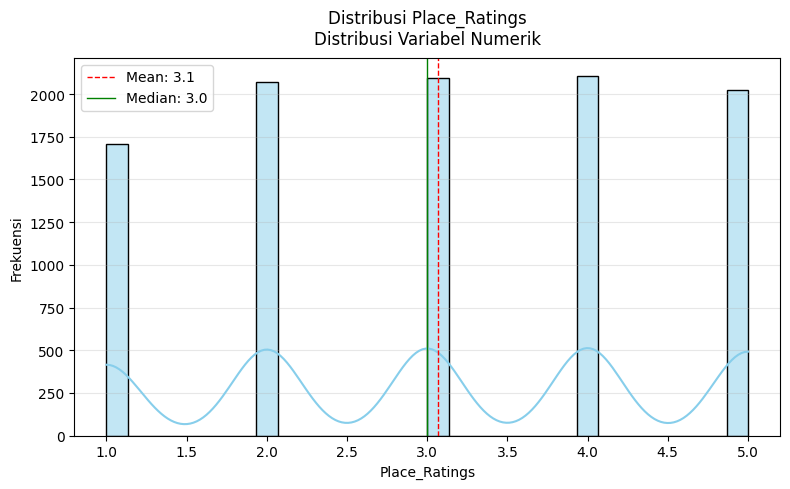

In [ ]:
numerical_columns = ['Place_Ratings']
df = rating.copy()
plt.figure(figsize=(8, 5))  # Reduced size since only one plot

col = numerical_columns[0]
ax = sns.histplot(data=df, x=col, kde=True, bins=30, color='skyblue')

mean_val = df[col].mean()
median_val = df[col].median()
plt.axvline(mean_val, color='r', ls='--', lw=1, label=f'Mean: {mean_val:.1f}')
plt.axvline(median_val, color='g', lw=1, label=f'Median: {median_val:.1f}')

plt.title(f'Distribusi {col}\nDistribusi Variabel Numerik', pad=10)
plt.xlabel(col)
plt.ylabel('Frekuensi')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Data Preparation

Sebelum membangun model rekomendasi, data perlu diproses terlebih dahulu untuk memastikan kualitas dan konsistensinya. Tahap persiapan data ini meliputi:
- **Menyatukan Dataframe**:
Data yang dimiliki saat ini tersebar ke beberapa dataset. Untuk dapat diolah lebih lanjut, perlu dilakukan penggabungan beberapa kolom ke dalma satu dataframe.

- **Standarisasi Format Fitur Kategorikal:**
Kategori yang ada pada fitur kategorikal bisa jadi belum seragam dan tidak konsisten. Selain itu, kita juga perlu mentransformasi nilainya menjadi satu string utuh agar dapat dengan mudah dimengerti oleh algoritma model.

- **Pemeriksaan Missing Values:**
Memastikan tidak ada data yang hilang (null/NaN) karena dapat mengganggu perhitungan similarity dan prediksi.

- **Penanganan Data Duplikat:**
Menghapus entri yang terduplikat untuk menghindari bias dalam rekomendasi, terutama dalam perhitungan rating.

- **Pengurutan dan Penyusunan Data:**
Mengorganisir data berdasarkan ID tempat wisata (Place_Id) agar lebih terstruktur dan memudahkan analisis distribusi rating.

- **Penyimpanan Data yang Sudah Dibersihkan:**
Menyimpan hasil data yang sudah diproses ke dalam variabel baru (preparation) untuk digunakan pada tahap berikutnya.

- **Persiapan Data untuk Pemodelan Content Based Filtering:**
Menyalin data 'preparation' dan misahkan kolom yang akan diolah ke dalam dataframe baru. Setelah itu dilakukan vektorisasi dengan TF-IDF.

- **Persiapan Data untuk Pemodelan Collaborative Filtering:**
Menyalin data 'preparation' dan melakukan encoding untuk fitur ID pengguna dan destinasi. Kemudian memisahkan variabel independen dan target (rating) yang sudah diacak. Sebelum di-_split_ dilakukan normalisasi variabel target, setelah itu data dibagi menjadi 80% data latih dan 20% data validasi.

**Mengapa Tahap Ini Penting?**
1. Memastikan data yang digunakan akurat dan konsisten.

2. Mencegah masalah teknis saat pembuatan model, seperti error akibat missing values atau duplikasi.

3. Meningkatkan kualitas rekomendasi dengan menghilangkan noise dalam data.

## Menggabungkan Kolom Nama dan Kategori Destinasi Wisata

Kode ini menggabungkan dataset rating dengan informasi nama tempat dan kategori dari dataset tourism menggunakan `Place_Id` sebagai key. Tujuan penggabungan ini adalah untuk memperkaya data rating dengan informasi deskriptif destinasi yang akan digunakan dalam content-based filtering. Penggunaan `how='left'` memastikan semua data rating tetap terjaga meskipun tidak ada match di data tourism.

In [ ]:
tourism_rating = pd.merge(rating, tourism[['Place_Id','Place_Name', 'Category']], on='Place_Id', how='left')
tourism_rating

,User_Id,Place_Id,Place_Ratings,Place_Name,Category
0,1,179,3,Candi Ratu Boko,Budaya
1,1,344,2,Pantai Marina,Bahari
2,1,5,5,Atlantis Water Adventure,Taman Hiburan
3,1,373,3,Museum Kereta Ambarawa,Budaya
4,1,101,4,Kampung Wisata Sosro Menduran,Budaya
...,...,...,...,...,...
9995,300,425,2,Waterpark Kenjeran Surabaya,Taman Hiburan
9996,300,64,4,Museum Sasmita Loka Ahmad Yani,Budaya
9997,300,311,3,The Lodge Maribaya,Cagar Alam
9998,300,279,4,Masjid Agung Trans Studio Bandung,Tempat Ibadah


## Standardisasi Format Kategori

Menampilkan semua kategori unik destinasi wisata yang ada. Langkah ini penting untuk memahami variasi jenis tempat wisata dalam dataset sebelum melakukan pemrosesan lebih lanjut. Hasilnya menunjukkan 6 kategori utama yang akan digunakan dalam sistem rekomendasi.

In [ ]:
tourism_rating['Category'].unique()

array(['Budaya', 'Bahari', 'Taman Hiburan', 'Cagar Alam',
       'Pusat Perbelanjaan', 'Tempat Ibadah'], dtype=object)

Mengganti **spasi** dalam nama kategori dengan **underscore** (misal "Taman Hiburan" → "Taman_Hiburan"). Ini dilakukan karena:

1. Memudahkan pemrosesan teks dalam analisis selanjutnya

2. Menghindari masalah parsing saat penyimpanan data

3. Mempermudah pembacaan ketika kategori digunakan sebagai fitur

In [ ]:
tourism_rating['Category'] = tourism_rating['Category'].replace('Taman Hiburan', 'Taman_Hiburan')
tourism_rating['Category'] = tourism_rating['Category'].replace('Cagar Alam', 'Cagar_Alam')
tourism_rating['Category'] = tourism_rating['Category'].replace('Pusat Perbelanjaan', 'Pusat_Perbelanjaan')
tourism_rating['Category'] = tourism_rating['Category'].replace('Tempat Ibadah', 'Tempat_Ibadah')

tourism_rating['Category'].unique()

array(['Budaya', 'Bahari', 'Taman_Hiburan', 'Cagar_Alam',
       'Pusat_Perbelanjaan', 'Tempat_Ibadah'], dtype=object)

## Pengecekan Data tourism

Menampilkan ringkasan metadata dari dataframe hasil penggabungan. Pengecekan ini memverifikasi bahwa:

- Tidak ada nilai null dalam dataset

- Tipe data setiap kolom sudah sesuai

- Struktur akhir dataframe sudah siap untuk tahap feature engineering

Output menunjukkan dataframe akhir terdiri dari 5 kolom: **`User_Id`, `Place_Id`, `Place_Ratings`, `Place_Name`, dan `Category`** - yang akan menjadi dasar untuk kedua pendekatan recommender system (content-based dan collaborative filtering).

In [ ]:
tourism_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_Id        10000 non-null  int64 
 1   Place_Id       10000 non-null  int64 
 2   Place_Ratings  10000 non-null  int64 
 3   Place_Name     10000 non-null  object
 4   Category       10000 non-null  object
dtypes: int64(3), object(2)
memory usage: 390.8+ KB


## Mengatasi Missing Value dan Duplikasi

Langkah ini dilakukan untuk memeriksa keberadaan nilai null/missing dalam dataset. Hal ini penting dilakukan untuk:
- Memastikan kelengkapan data sebelum pemrosesan lebih lanjut
- Data yang tidak lengkap dapat menyebabkan error dalam pembuatan model
- **Hasil**: Tidak ditemukan missing values di kolom manapun, menunjukkan data sudah bersih dari nilai kosong

In [ ]:
tourism_rating.isnull().sum()

,0
User_Id,0
Place_Id,0
Place_Ratings,0
Place_Name,0
Category,0


Selanjutnya adalah mengecek jumlah record duplikat. Hal ini perlu dilakukan karena:
- Data duplikat dapat menyebabkan bias dalam model rekomendasi
- Dapat mengganggu perhitungan similarity dalam collaborative filtering
- Memastikan setiap entri unik meningkatkan kualitas rekomendasi
- Penghapusan duplikat meningkatkan kualitas data tanpa mengurangi variasi rating

Dari hasil ini ditemukan terdapat 79 baris yang duplikat. Sel-sel di bawah ini akan Menghapus duplikat dan memverifikasi hasilnya.

**Efek**: Jumlah record berkurang dari **10.000 menjadi 9.921** setelah pembersihan



In [ ]:
tourism_rating.duplicated().sum()

np.int64(79)

In [ ]:
tourism_rating.drop_duplicates(inplace=True)
tourism_rating.duplicated().sum()

np.int64(0)

## Penyiapan Data Final

Terakhir, membuat variabel preparation sebagai working copy dan mengurutkan data berdasarkan Place_Id.

Langkah ini dilakukan untuk:
- Mempermudah analisis eksploratif dengan melihat rating per destinasi
- Membantu visualisasi pola rating antar tempat wisata
- Persiapan untuk tahap transformasi data berikutnya

**Struktur Data:**
- Terdapat 9.921 entri valid
- 5 kolom utama (User_Id, Place_Id, Place_Ratings, Place_Name, Category)

Dataset yang sudah dibersihkan ini siap untuk tahap feature engineering dan pembuatan model.

In [ ]:
preparation = tourism_rating
preparation.sort_values('Place_Id')

,User_Id,Place_Id,Place_Ratings,Place_Name,Category
8426,254,1,5,Monumen Nasional,Budaya
1145,36,1,4,Monumen Nasional,Budaya
3417,105,1,5,Monumen Nasional,Budaya
1203,38,1,2,Monumen Nasional,Budaya
7552,227,1,5,Monumen Nasional,Budaya
...,...,...,...,...,...
2043,63,437,4,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat_Ibadah
9888,297,437,4,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat_Ibadah
4222,129,437,4,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat_Ibadah
47,2,437,4,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat_Ibadah


## Persiapan Data untuk Model Content Based Filtering

Data disiapkan dengan membuat salinan (`copy()`) dari dataset utama untuk memastikan perubahan tidak memengaruhi data asli. Selanjutnya, duplikat berdasarkan `Place_Id` dihilangkan karena dalam *content-based filtering*, kita hanya memerlukan informasi unik setiap destinasi (nama, kategori) tanpa mempertimbangkan rating dari pengguna yang berbeda. Hasilnya adalah dataframe dengan **437 destinasi unik**, siap untuk ekstraksi fitur.

In [ ]:
preparation_CBF = preparation.copy()  # Membuat salinan dataset
preparation_CBF = preparation_CBF.drop_duplicates('Place_Id')  # Menghapus destinasi duplikat
preparation_CBF

,User_Id,Place_Id,Place_Ratings,Place_Name,Category
0,1,179,3,Candi Ratu Boko,Budaya
1,1,344,2,Pantai Marina,Bahari
2,1,5,5,Atlantis Water Adventure,Taman_Hiburan
3,1,373,3,Museum Kereta Ambarawa,Budaya
4,1,101,4,Kampung Wisata Sosro Menduran,Budaya
...,...,...,...,...,...
2008,62,370,1,Benteng Pendem,Budaya
2399,74,350,4,Pantai Cipta,Bahari
2448,75,10,2,Pulau Tidung,Bahari
2534,78,7,4,Kebun Binatang Ragunan,Cagar_Alam


### Ekstraksi Informasi Destinasi Wisata

Informasi destinasi (ID, nama, kategori) diubah menjadi list untuk memudahkan pembuatan dataframe baru. Ini dilakukan karena content-based filtering hanya memerlukan metadata destinasi (bukan data rating). Output menunjukkan 437 entri untuk setiap list, menegaskan konsistensi data.

In [ ]:
tourism_id = preparation_CBF['Place_Id'].tolist()  # List ID destinasi
tourism_name = preparation_CBF['Place_Name'].tolist()  # List nama destinasi
tourism_category = preparation_CBF['Category'].tolist()  # List kategori destinasi

print(len(tourism_id))
print(len(tourism_name))
print(len(tourism_category))

437
437
437


Dataframe tourism_new dibuat dengan struktur sederhana (id, destination, category) untuk fokus pada fitur yang relevan, yaitu kategori destinasi, yang akan menjadi dasar perhitungan kesamaan (similarity).

In [ ]:
tourism_data = pd.DataFrame({
    'id': tourism_id,
    'destination': tourism_name,
    'category': tourism_category
})
tourism_data

,id,destination,category
0,179,Candi Ratu Boko,Budaya
1,344,Pantai Marina,Bahari
2,5,Atlantis Water Adventure,Taman_Hiburan
3,373,Museum Kereta Ambarawa,Budaya
4,101,Kampung Wisata Sosro Menduran,Budaya
...,...,...,...
432,370,Benteng Pendem,Budaya
433,350,Pantai Cipta,Bahari
434,10,Pulau Tidung,Bahari
435,7,Kebun Binatang Ragunan,Cagar_Alam


### Vektorisasi dengan TF-IDF

Inti dari content-based filtering terletak pada kemampuan sistem memahami karakteristik setiap destinasi. Untuk itu, kita menerapkan teknik TF-IDF (Term Frequency-Inverse Document Frequency) pada kolom kategori. Proses ini mengubah teks kategori menjadi representasi numerik yang menangkap seberapa penting suatu kategori dalam mendefinisikan sebuah destinasi. Hasil transformasi ini berupa matriks sparse dimana setiap baris merepresentasikan sebuah destinasi dan setiap kolom merepresentasikan kategori.

Ketika kita memeriksa variasi kategori destinasi wisata menggunakan sel di bawah ini, sistem mengungkapkan enam kategori unik yang menjadi dasar klasifikasi: 'Budaya', 'Bahari', 'Taman_Hiburan', 'Cagar_Alam', 'Pusat_Perbelanjaan', dan 'Tempat_Ibadah'. Kategori-kategori ini mewakili keragaman jenis wisata yang ada dalam dataset kita, mulai dari wisata sejarah hingga alam dan hiburan.

In [ ]:
tourism_data['category'].unique()

array(['Budaya', 'Bahari', 'Taman_Hiburan', 'Cagar_Alam',
       'Pusat_Perbelanjaan', 'Tempat_Ibadah'], dtype=object)

Untuk memproses informasi kategori ini secara komputasional, kita menerapkan teknik TF-IDF (Term Frequency-Inverse Document Frequency) melalui tiga tahap utama. Pertama, kita menginisialisasi model TF-IDF dengan `TfidfVectorizer()`, yang akan bertugas mengubah teks kategori menjadi representasi numerik. Kemudian, kita mentransformasikan kolom kategori menjadi matriks TF-IDF menggunakan `fit_transform()`, sebuah proses yang secara cerdas memberikan bobot numerik pada setiap kategori berdasarkan seberapa khas suatu kategori dalam mendefinisikan sebuah destinasi.

In [ ]:
tfidf = TfidfVectorizer()  # Inisialisasi TF-IDF

tfidf_matrix = tfidf.fit_transform(tourism_data['category'])  # Transformasi kategori ke matriks TF-IDF

tfidf.get_feature_names_out() # Mengoutput fitur tfidf untuk kategori

array(['bahari', 'budaya', 'cagar_alam', 'pusat_perbelanjaan',
       'taman_hiburan', 'tempat_ibadah'], dtype=object)

Ketika kita memeriksa fitur yang dihasilkan dengan get_feature_names_out(), terlihat bahwa nama-nama kategori telah dinormalisasi menjadi format lowercase: `['bahari', 'budaya', 'cagar_alam', 'pusat_perbelanjaan', 'taman_hiburan', 'tempat_ibadah']`. Normalisasi ini memastikan konsistensi dalam pemrosesan teks.

In [ ]:
tfidf_matrix.shape

(437, 6)

Hasil transformasi menghasilkan matriks TF-IDF berukuran 437 baris (sesuai jumlah destinasi) dan 6 kolom (sesuai jumlah kategori). Ketika kita melihat representasi padat (dense) dari matriks ini melalui `todense()`, pola yang menarik terungkap. Setiap baris matriks menunjukkan distribusi bobot kategori untuk satu destinasi tertentu. Misalnya, destinasi pertama memiliki bobot 1 untuk kategori 'budaya' dan 0 untuk kategori lainnya, menunjukkan bahwa destinasi ini murni tergolong wisata budaya. Pola ini konsisten di seluruh dataset, di mana setiap destinasi secara eksklusif dikaitkan dengan satu kategori tertentu.

In [ ]:
tfidf_matrix.todense()

matrix([[0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.]])

Untuk memahami bagaimana sistem merepresentasikan kategori setiap destinasi, kita membuat visualisasi parsial dari matriks TF-IDF. Dengan mengkonversi matriks sparse menjadi DataFrame yang lebih mudah dibaca, kita dapat melihat contoh 10 destinasi acak dan distribusi bobot kategorinya. Pada tabel yang dihasilkan, terlihat pola yang sangat jelas, setiap destinasi secara eksklusif memiliki bobot 1 untuk satu kategori dan 0 untuk kategori lainnya.

Sebagai contoh, 'Tebing Breksi' diklasifikasikan sebagai 'budaya', sementara 'Desa Wisata Pulesari' tergolong 'taman_hiburan'. Representasi biner ini mencerminkan sifat eksklusif dari klasifikasi destinasi dalam dataset kita, dimana satu tempat wisata hanya dimasukkan dalam satu kategori tertentu.

In [ ]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=tourism_data.destination
).sample(6, axis=1).sample(10, axis=0)

,bahari,tempat_ibadah,pusat_perbelanjaan,taman_hiburan,cagar_alam,budaya
destination,,,,,,
Museum Nike Ardilla,0.0,0.0,0.0,0.0,0.0,1.0
Embung Tambakboyo,0.0,0.0,0.0,1.0,0.0,0.0
Obyek Wisata Goa Kreo,0.0,0.0,0.0,0.0,1.0,0.0
Keraton Surabaya,0.0,0.0,0.0,0.0,0.0,1.0
Wisata Agro Edukatif Istana Susu Cibugary,0.0,0.0,0.0,1.0,0.0,0.0
Museum Sumpah Pemuda,0.0,0.0,0.0,0.0,0.0,1.0
Gereja Perawan Maria Tak Berdosa Surabaya,0.0,1.0,0.0,0.0,0.0,0.0
Monumen Jalesveva Jayamahe,0.0,0.0,0.0,0.0,0.0,1.0
Goa Rancang Kencono,0.0,0.0,0.0,0.0,1.0,0.0


## Persiapan Data untuk Model Collaborative Filtering

### Persiapan Data dan Encoding

Tahap pertama dalam persiapan model collaborative filtering dimulai dengan membuat salinan dataset asli ke dalam variabel `df` untuk menjaga integritas data original. Dataset ini berisi 9.921 entri yang merekam interaksi antara pengguna (User_Id) dan destinasi wisata (Place_Id), lengkap dengan rating (Place_Ratings), nama tempat (Place_Name), serta kategori wisata (Category).

In [ ]:
df = preparation.copy()
df

,User_Id,Place_Id,Place_Ratings,Place_Name,Category
0,1,179,3,Candi Ratu Boko,Budaya
1,1,344,2,Pantai Marina,Bahari
2,1,5,5,Atlantis Water Adventure,Taman_Hiburan
3,1,373,3,Museum Kereta Ambarawa,Budaya
4,1,101,4,Kampung Wisata Sosro Menduran,Budaya
...,...,...,...,...,...
9995,300,425,2,Waterpark Kenjeran Surabaya,Taman_Hiburan
9996,300,64,4,Museum Sasmita Loka Ahmad Yani,Budaya
9997,300,311,3,The Lodge Maribaya,Cagar_Alam
9998,300,279,4,Masjid Agung Trans Studio Bandung,Tempat_Ibadah


Untuk mempersiapkan data agar dapat diproses oleh model machine learning, dilakukan proses encoding terhadap ID pengguna dan ID tempat wisata. Pertama, kita mengidentifikasi semua user ID unik dan membuat dua mapping dictionary: user_to_user_encoded yang mengkonversi ID asli ke indeks numerik (misal User_Id 1 → 0), dan user_encoded_to_user sebagai kebalikannya untuk keperluan dekoding nanti. Proses serupa dilakukan untuk Place_Id, menghasilkan place_to_place_encoded dan place_encoded_to_place. Hasil encoding ini kemudian ditambahkan sebagai kolom baru user_encoded dan place_encoded di dataframe, mengubah ID asli menjadi indeks numerik berurutan yang lebih efisien untuk diproses oleh model neural network. Id sebelum dilakukan encoding dimulai dari 1, sedangkan setelah diencoding akan dimulai dari 0.

In [ ]:
user_ids = df['User_Id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
df['user_encoded'] = df['User_Id'].map(user_to_user_encoded)

In [ ]:
place_ids = df['Place_Id'].unique().tolist()
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}
df['place_encoded'] = df['Place_Id'].map(place_to_place_encoded)

In [ ]:
df.head(5)

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,user_encoded,place_encoded
0,1,179,3,Candi Ratu Boko,Budaya,0,0
1,1,344,2,Pantai Marina,Bahari,0,1
2,1,5,5,Atlantis Water Adventure,Taman_Hiburan,0,2
3,1,373,3,Museum Kereta Ambarawa,Budaya,0,3
4,1,101,4,Kampung Wisata Sosro Menduran,Budaya,0,4


Dengan menghitung jumlah unik pengguna (jumlah_user) dan destinasi wisata (jumlah_destinasi), kita mengetahui model akan menghadapi 300 pengguna berbeda dan 437 destinasi wisata unik. Pengecekan nilai minimum (min_rating=1) dan maksimum (max_rating=5) pada kolom rating mengkonfirmasi skala penilaian yang digunakan, informasi krusial untuk normalisasi nilai rating nantinya. Statistik dasar ini memberikan gambaran kompleksitas masalah rekomendasi yang dihadapi dan membantu menentukan kapasitas model yang sesuai.

In [ ]:
jumlah_user = df['user_encoded'].nunique()

jumlah_destinasi = df['place_encoded'].nunique()

min_rating = min(df['Place_Ratings'])

max_rating = max(df['Place_Ratings'])

print(f"Jumlah user: {jumlah_user}\nJumlah destinasi: {jumlah_destinasi}\nMin Rating: {min_rating}\nMax Rating: {max_rating}")

Jumlah user: 300
Jumlah destinasi: 437
Min Rating: 1
Max Rating: 5


### Train-Validation Split

Dataset diacak secara menyeluruh menggunakan sample(frac=1) dengan random state 42 untuk memastikan distribusi data yang seragam sebelum pembagian. Randomisasi ini penting untuk menghindari bias akibat pola urutan tertentu dalam data asli. Hasil pengacakan menunjukkan distribusi yang baik dimana contoh baris yang ditampilkan mencerminkan variasi user (User_Id), destinasi (Place_Id), dan rating yang beragam. Kolom tambahan user_encoded dan place_encoded yang telah dibuat sebelumnya tetap dipertahankan sebagai representasi numerik yang akan digunakan model.

In [ ]:
df = df.sample(frac=1, random_state=42)
df

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,user_encoded,place_encoded
5315,161,260,2,Museum Pos Indonesia,Budaya,160,259
518,17,262,2,Wot Batu,Cagar_Alam,16,54
4362,133,191,5,Pantai Drini,Bahari,132,240
8447,255,156,1,Pantai Pulang Sawal,Bahari,254,241
9105,274,78,3,Hutan Kota Srengseng,Taman_Hiburan,273,35
...,...,...,...,...,...,...,...
5782,174,296,3,Batununggal Indah Club,Taman_Hiburan,173,154
5237,159,69,4,Freedom Library,Budaya,158,406
5437,164,24,5,Museum Nasional,Budaya,163,74
871,28,131,5,Watu Lumbung,Cagar_Alam,27,70


Variabel independen x dibentuk dari gabungan dua kolom encoded (user_encoded dan place_encoded) yang merepresentasikan interaksi antara user dan destinasi. Sementara variabel target y berisi nilai rating yang dinormalisasi ke range 0-1 menggunakan min-max scaling, dengan formula (x - min_rating)/(max_rating - min_rating). Normalisasi ini membantu stabilisasi proses pembelajaran model neural network dengan menyamakan skala semua fitur. Transformasi rating ke interval [0,1] juga memudahkan penggunaan fungsi aktivasi sigmoid di layer output nanti.

In [ ]:
# Membuat variabel x menggunakan ID yang sudah di-encode
x = df[['user_encoded', 'place_encoded']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

Dataset dibagi menjadi training set (80%) dan validation set (20%) dengan proporsi yang terjaga. Pembagian dilakukan secara sequential setelah pengacakan, menghasilkan 7,936 sampel training dan 1,985 sampel validasi. Ukuran validasi set yang mencukupi ini memungkinkan evaluasi model yang reliable tanpa mengurangi data training secara berlebihan.

In [ ]:
print(f'Total # of sample in whole dataset: {len(x)}')
print(f'Total # of sample in train dataset: {len(x_train)}')
print(f'Total # of sample in test dataset: {len(x_val)}')

Total # of sample in whole dataset: 9921
Total # of sample in train dataset: 7936
Total # of sample in test dataset: 1985


# Model Development

## Content Based Filtering

Pada tahap ini, kita akan membangun sistem rekomendasi berbasis konten dengan memanfaatkan kategori destinasi wisata sebagai fitur utama. Proses dilakukan dnegan melakukan perhitungan cosine similarity dar matriks TF-IDF guna mengidentifikasi kemiripan antar destinasi. Hasilnya adalah model yang mampu merekomendasikan destinasi serupa berdasarkan kesamaan kategori. Pendekatan ini efektif untuk personalisasi rekomendasi berdasarkan karakteristik objek wisata itu sendiri.

### Perhitungan Cosine Similarity

Proses inti dari sistem rekomendasi ini adalah menghitung tingkat kesamaan antar destinasi menggunakan cosine similarity. Ketika kita menerapkan fungsi cosine_similarity pada matriks TF-IDF, dihasilkanlah matriks simetri berukuran 437x437 yang menangkap hubungan kemiripan antara semua pasangan destinasi. Matriks ini menunjukkan nilai 1 pada diagonal utama (karena setiap destinasi pasti identik dengan dirinya sendiri) dan nilai 0 atau 1 di elemen lainnya. Nilai 1 muncul ketika dua destinasi berbagi kategori yang sama, sementara 0 menunjukkan destinasi dengan kategori berbeda.

In [ ]:
# Matriks TF-IDF dari hasil data preparation
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

Untuk membuat matriks similarity lebih interpretatif, kita mengubahnya menjadi DataFrame dengan nama destinasi sebagai indeks dan kolom. Hasilnya adalah tabel besar berukuran 437x437 yang memetakan hubungan similarity seluruh destinasi. Pada contoh visualisasi acak 10x10, kita bisa melihat pola menarik - destinasi dengan kategori sama memiliki similarity 1, seperti kelompok wisata alam di 'Puncak Gunung Api Purba - Nglanggeran', 'Umbul Sidomukti', dan 'Perkebunan Teh Malabar' yang saling terkait. Sebaliknya, destinasi dengan kategori berbeda seperti 'Hutan Mangrove Kulon Progo' ('Cagar Alam') menunjukkan similarity 0 dengan destinasi tempat ibadah atau taman hiburan.

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=tourism_data['destination'], columns=tourism_data['destination'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Shape: (437, 437)


destination,Kampung Wisata Taman Sari,Taman Lapangan Banteng,Umbul Sidomukti,Perkebunan Teh Malabar,Nol Kilometer Jl.Malioboro,Museum Mpu Tantular,Atlantis Land Surabaya,Grand Maerakaca,Pantai Drini,Pasar Tanah Abang
destination,,,,,,,,,,
Puncak Gunung Api Purba - Nglanggeran,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Desa Wisata Gamplong,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
Pantai Indrayanti,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Hutan Mangrove Kulon Progo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Tugu Proklamasi,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Candi Ratu Boko,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Kampung Wisata Sosro Menduran,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Happyfarm Ciwidey,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Tafso Barn,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Implementasi Fungsi Rekomendasi Destinasi Wisata

Fungsi `destination_recommendations` dirancang untuk memberikan rekomendasi destinasi wisata berdasarkan kemiripan kategori. Fungsi ini bekerja melalui beberapa tahap: pertama, mencari destinasi paling mirip dari matriks similarity menggunakan teknik partisi untuk efisiensi, lalu mengambil sejumlah rekomendasi teratas (default 5) dan menghilangkan destinasi input jika terdapat dalam hasil. Terakhir, fungsi menggabungkan hasil dengan informasi kategori dari dataset asli. Outputnya berupa DataFrame yang menampilkan nama destinasi rekomendasi beserta kategorinya, memberikan rekomendasi yang relevan sekaligus informatif bagi pengguna.

In [ ]:
def destination_recommendations(destination, similarity_data=cosine_sim_df, items=tourism_data[['destination', 'category']], k=5):
    # Ambil indeks destinasi yang paling mirip
    index = similarity_data.loc[:,destination].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]  # Ambil top-k
    closest = closest.drop(destination, errors='ignore')  # Hapus destinasi input jika ada
    return pd.DataFrame(closest).merge(items).head(k)  # Gabungkan dengan info kategori

Ketika fungsi diuji dengan parameter ID Destinasi 400, sistem mengaitkan nama destinasi dengan ID 400 dan memasukkannya ke dalam fungsi recommendation. Setelah itu, sistem berhasil memberikan lima rekomendasi destinasi lain dalam kategori yang sama.

Nama destinasi dengan ID 400 adalah Hutan Bambu Keputih (Kategori: Cagar_Alam). Sistem menghasilkan 5 rekomendasi destinasi yang berkaitan dengan kategori Cagar_Alam.

In [ ]:
data = preparation_CBF.copy()
Place_Id = 400 # Input ID Destinasi yang ingin dicari
destination = data.loc[data['Place_Id'] == Place_Id, 'Place_Name'].iloc[0]

recommendations_result_df = destination_recommendations(destination)

print(f"\n✨ Rekomendasi Destinasi Serupa untuk: {destination} (Kategori: {data[data['Place_Name'] == destination]['Category'].iloc[0]})")
print("=" * 60) # Sesuaikan lebar garis

if recommendations_result_df.empty:
    print("   Tidak ada rekomendasi yang dapat ditampilkan.")
else:
    print(f"{'No.':<4} {'Destination':<40} | {'Category':<20}")
    print("-" * 60)
    for idx, row in enumerate(recommendations_result_df.itertuples(), 1):
        # Asumsikan recommendations_result_df memiliki kolom 'destination' dan 'category'
        dest_name = str(row.destination)
        cat_name = str(row.category)
        print(f"{idx:<4} {dest_name:<40} | {cat_name:<20}")
print("-" * 60)


✨ Rekomendasi Destinasi Serupa untuk: Hutan Bambu Keputih (Kategori: Cagar_Alam)
No.  Destination                              | Category            
------------------------------------------------------------
1    Gunung Papandayan                        | Cagar_Alam          
2    Gua Maria Kerep Ambarawa                 | Cagar_Alam          
3    Bukit Paralayang, Watugupit              | Cagar_Alam          
4    Ekowisata Mangrove Wonorejo              | Cagar_Alam          
5    Cibubur Garden Diary (Cibugary)          | Cagar_Alam          
------------------------------------------------------------


## Collaborative Filtering

### Arsitektur Model

Kelas RecommenderNet yang merupakan turunan dari tf.keras.Model dirancang khusus untuk menangani tugas collaborative filtering dengan pendekatan embedding. Dalam konstruktor kelas, kita mendefinisikan beberapa komponen utama: embedding layer untuk user dan destinasi beserta bias term masing-masing. Embedding layer ini akan memetakan ID user dan destinasi ke ruang vektor berdimensi tertentu (dalam kasus ini 8 dimensi), di mana vektor-vektor ini akan dipelajari selama proses training untuk menangkap preferensi tersembunyi (latent features). Inisialisasi bobot menggunakan 'he_normal' dan regularisasi L2 membantu menjaga nilai embedding tetap stabil dan mencegah overfitting. Komponen bias ditambahkan untuk menangkap efek spesifik dari masing-masing user dan destinasi yang tidak tercakup dalam embedding.

Pada metode call, model melakukan serangkaian operasi untuk menghasilkan prediksi rating. Pertama, model mengambil embedding vector untuk user dan destinasi dari input. Dot product antara user vector dan destination vector dihitung untuk mengukur kesesuaian (affinity) antara user dan destinasi, yang kemudian ditambahkan dengan bias term dari user dan destinasi. Hasilnya dilewatkan melalui fungsi aktivasi sigmoid untuk memetakan prediksi ke range 0-1, sesuai dengan rating yang telah dinormalisasi sebelumnya. Arsitektur ini mengimplementasikan konsep matrix factorization dengan neural network, di mana model belajar faktor-faktor laten yang menjelaskan interaksi user dengan destinasi.

In [ ]:
import tensorflow as tf

class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_destination, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_destination = num_destination
    self.embedding_size = embedding_size

    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-4),
        name='user_embedding_layer'
    )
    self.user_bias = layers.Embedding(num_users, 1, name='user_bias_layer')

    self.destination_embedding = layers.Embedding(
        num_destination,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-4),
        name='destination_embedding_layer'
    )
    self.destination_bias = layers.Embedding(num_destination, 1, name='destination_bias_layer')

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])

    destination_vector = self.destination_embedding(inputs[:, 1])
    destination_bias = self.destination_bias(inputs[:, 1])

    dot_user_destination = tf.tensordot(user_vector, destination_vector, 2)
    x_interaction = dot_user_destination + user_bias + destination_bias

    return tf.nn.sigmoid(x_interaction)

### Inisialisasi Hyperparameter dan Pelatihan Model

Model diinisialisasi dengan parameter sesuai jumlah user dan destinasi unik yang ada di dataset. Dua callback penting ditambahkan: EarlyStopping untuk menghentikan training jika validasi loss tidak membaik dalam 10 epoch berturut-turut (sambil menyimpan bobot terbaik), dan ReduceLROnPlateau yang secara otomatis mengurangi learning rate ketika validasi loss stagnan selama 5 epoch. Callback-callback ini membantu optimasi proses training dan mencegah overfitting. Learning rate awal diatur sebesar 0.001 dengan batas bawah 0.00001, memberikan ruang bagi optimizer untuk melakukan penyempurnaan halus di akhir training.

Model dikompilasi dengan loss function Mean Squared Error yang sesuai untuk prediksi nilai antara 0-1, optimizer Adam yang efisien, dan metrik RMSE untuk evaluasi.

In [ ]:
num_users = len(df['User_Id'].unique())
num_destination = len(df['Place_Id'].unique())
model = RecommenderNet(num_users, num_destination, 8) # inisialisasi model

early_stopping = EarlyStopping(
    monitor='val_loss',      # Metrik yang dipantau
    patience=10,             # Jumlah epoch tanpa perbaikan sebelum berhenti
    verbose=1,               # Tampilkan pesan saat callback diaktifkan
    restore_best_weights=True # Kembalikan bobot dari epoch terbaik
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Metrik yang dipantau
    factor=0.1,              # Faktor pengurangan learning rate (new_lr = lr * factor)
    patience=5,             # Jumlah epoch tanpa perbaikan sebelum LR dikurangi
    verbose=1,               # Tampilkan pesan saat callback diaktifkan
    min_lr=0.00001           # Batas bawah learning rate
)

# model compile
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

Proses pelatihan model neural collaborative filtering dimulai dengan menjalankan fungsi fit() pada model yang telah dikompilasi sebelumnya. Dalam tahap ini, model secara iteratif mempelajari pola-pola tersembunyi dari data rating yang diberikan untuk memprediksi preferensi pengguna terhadap destinasi wisata yang belum mereka kunjungi. Pelatihan dilakukan dengan konfigurasi batch size sebesar 125, yang berarti model akan memproses 125 sampel data sekaligus sebelum melakukan pembaruan bobot, menyeimbangkan antara efisiensi memori dan stabilitas pembelajaran. Parameter epochs diatur ke 100 sebagai batas maksimum iterasi, meskipun dalam praktiknya pelatihan akan berhenti lebih awal melalui mekanisme early stopping jika tidak ada peningkatan pada validation loss.

Penggunaan batch size yang cukup besar membantu stabilisasi gradient descent, sementara pembagian validasi yang cukup besar memungkinkan evaluasi model yang lebih reliable. Selama training, model akan mempelajari embedding vector yang mampu memprediksi rating user terhadap destinasi wisata berdasarkan pola interaksi yang ada.

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 125,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1212 - root_mean_squared_error: 0.3437 - val_loss: 0.1268 - val_root_mean_squared_error: 0.3519 - learning_rate: 0.0010
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1217 - root_mean_squared_error: 0.3447 - val_loss: 0.1264 - val_root_mean_squared_error: 0.3515 - learning_rate: 0.0010
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1211 - root_mean_squared_error: 0.3440 - val_loss: 0.1261 - val_root_mean_squared_error: 0.3512 - learning_rate: 0.0010
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1213 - root_mean_squared_error: 0.3443 - val_loss: 0.1260 - val_root_mean_squared_error: 0.3512 - learning_rate: 0.0010
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1197 - root_mean_squared_error: 0.3422 - val_loss: 0.1257 - val_root_mean_squared_error: 0.3510 - learning_rate: 0.0010
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1183 - root_mean_squared_error: 0.

Selama proses pelatihan, beberapa fenomena penting dapat diamati dari output yang dihasilkan. Pada epoch-epoch awal (1-13), terlihat penurunan yang stabil baik pada training loss maupun validation loss, menunjukkan model sedang mempelajari pola-pola dasar dari data. Nilai RMSE (Root Mean Squared Error) yang dihasilkan berada sekitar 0.350-0.351, mengindikasikan tingkat error prediksi yang relatif konsisten. Namun mulai epoch 14-25, validation loss mulai stagnan dan meningkat sementara training loss terus menurun perlahan, tanda awal bahwa model mulai kesulitan menemukan pola baru dan berpotensi overfitting. Pada epoch 18, callback ReduceLROnPlateau terpicu dan mengurangi learning rate dari 0.001 menjadi 0.0001, upaya untuk membantu model keluar dari titik stagnan dengan langkah pembaruan yang lebih halus.

Setelah penurunan learning rate, model melanjutkan pelatihan dengan learning rate yang lebih kecil (epoch 18-23). Pada fase ini, meskipun training loss masih menunjukkan penurunan sangat perlahan, validation loss tetap tidak menunjukkan perbaikan yang signifikan. Pada epoch 23, terjadi penurunan learning rate kedua ke nilai 0.00001 dan callback early stopping akhirnya menghentikan pelatihan di epoch 25 karena validation loss tidak membaik selama 10 epoch berturut-turut sejak epoch 15. Model kemudian mengembalikan bobot dari epoch terbaik (epoch 15) yang memiliki performa validasi optimal. Proses ini menunjukkan efektivitas mekanisme regularisasi dan callback dalam mencegah overfitting sekaligus memastikan model tidak membuang waktu komputasi untuk pelatihan yang tidak produktif.

Hasil akhir pelatihan menunjukkan model mencapai keseimbangan yang baik antara kemampuan pembelajaran (training loss 0.1144) dan generalisasi (validation loss 0.1247) pada epoch terbaik. Nilai RMSE akhir sekitar 0.35 pada skala rating yang telah dinormalisasi (setara dengan error prediksi sekitar 0.175 pada skala rating asli 1-5 setelah denormalisasi) menunjukkan tingkat akurasi yang dapat diterima untuk sistem rekomendasi. Proses pelatihan ini berhasil menangkap pola preferensi pengguna tanpa overfitting berlebihan, menghasilkan model yang siap digunakan untuk memberikan rekomendasi personalisasi.

### Inferensi dan Contoh Penggunaan

Pada tahap awal ini, sistem mempersiapkan data yang diperlukan untuk menghasilkan rekomendasi personalisasi bagi pengguna tertentu. Proses dimulai dengan mengambil user_id dari baris 0 sebagai contoh untuk demonstrasi rekomendasi. Sistem kemudian mengidentifikasi destinasi-destinasi yang telah dikunjungi oleh pengguna tersebut dengan melakukan filter pada dataset rating.

Selanjutnya, sistem menentukan destinasi-destinasi yang belum pernah dikunjungi oleh pengguna dengan membandingkan daftar semua destinasi wisata (tourism_df) terhadap destinasi yang sudah dikunjungi (destination_visited_by_user). Proses ini melibatkan konversi ID destinasi menjadi encoded values yang sesuai dengan representasi yang digunakan selama pelatihan model, menggunakan dictionary place_to_place_encoded yang telah dibuat sebelumnya.

Terakhir, sistem menyiapkan input array untuk model dengan menggabungkan encoded user_id dengan encoded destinasi yang belum dikunjungi, menciptakan pasangan user-destinasi yang akan diprediksi ratingnya.

In [ ]:
tourism_df = tourism_data
df = rating

# Mengambil sample user
user_id = df.User_Id.iloc[0] # User_Id = 1
destination_visited_by_user = df[df.User_Id == user_id]

destination_not_visited = tourism_df[~tourism_df['id'].isin(destination_visited_by_user.Place_Id.values)]['id']
destination_not_visited = list(
    set(destination_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)

destination_not_visited = [[place_to_place_encoded.get(x)] for x in destination_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_destination_array = np.hstack(
    ([[user_encoder]] * len(destination_not_visited), destination_not_visited)
)

Tahap ini merupakan inti dari sistem rekomendasi dimana model yang telah dilatih digunakan untuk memprediksi rating potensial dari destinasi-destinasi yang belum dikunjungi pengguna.

Model melakukan prediksi (`model.predict`) pada array user-destinasi yang telah disiapkan sebelumnya, menghasilkan skor rating untuk setiap destinasi.

Sistem kemudian mengurutkan destinasi berdasarkan skor prediksi tersebut dan mengambil 10 destinasi dengan skor tertinggi. Untuk menampilkan hasil yang informatif, sistem dibagi menjadi dua bagian utama: pertama menampilkan 5 destinasi favorit pengguna berdasarkan rating tertinggi yang telah diberikan sebelumnya (memberikan konteks tentang preferensi pengguna), dan kedua menampilkan 10 rekomendasi destinasi baru yang diprediksi akan disukai oleh pengguna tersebut.

Format output dirancang secara visual dengan pembatas garis (= dan -) dan kolom yang rapi, mencakup nomor urut, nama destinasi, dan kategori wisata, sehingga mudah dibaca dan dipahami oleh pengguna akhir.

Hasil rekomendasi ini menunjukkan kemampuan model dalam memahami pola preferensi pengguna dan menggeneralisasikannya ke destinasi-destinasi yang belum dikunjungi.

In [ ]:
# Prediksi rating untuk destinasi yang belum dikunjungi oleh user
ratings = model.predict(user_destination_array).flatten()

# Ambil 10 destinasi dengan rating tertinggi
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_destination_ids = [
    place_encoded_to_place.get(destination_not_visited[x][0]) for x in top_ratings_indices
]

# Tampilkan header
print(f"\n🎯 Showing Recommendations for User ID: {user_id}")
print("=" * 60)

# Top 5 destinasi yang sudah dikunjungi user berdasarkan rating tertinggi
print("\n📌 Top 5 Destinations Visited by User (Based on Rating):")
print("-" * 60)
print(f"{'No.':<4} {'Destination':<35} | {'Category':<20}")
print("-" * 60)

top_destination_user = (
    destination_visited_by_user.sort_values(
        by='Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)

tourism_df_rows = tourism_df[tourism_df['id'].isin(top_destination_user)]
for idx, row in enumerate(tourism_df_rows.itertuples(), 1):
    print(f"{idx:<4} {row.destination:<35} | {row.category:<20}")

# Top 10 rekomendasi destinasi
print("\n✨ Top 10 Destination Recommendations for User:")
print("-" * 60)
print(f"{'No.':<4} {'Destination':<35} | {'Category':<20}")
print("-" * 60)

recommended_destination = tourism_df[tourism_df['id'].isin(recommended_destination_ids)]
for idx, row in enumerate(recommended_destination.itertuples(), 1):
    print(f"{idx:<4} {row.destination:<35} | {row.category:<20}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🎯 Showing Recommendations for User ID: 1

📌 Top 5 Destinations Visited by User (Based on Rating):
------------------------------------------------------------
No.  Destination                         | Category            
------------------------------------------------------------
1    Atlantis Water Adventure            | Taman_Hiburan       
2    Museum Gedung Sate                  | Budaya              
3    Taman Harmoni Keputih               | Cagar_Alam          
4    Taman Sungai Mudal                  | Cagar_Alam          
5    Surabaya North Quay                 | Taman_Hiburan       

✨ Top 10 Destination Recommendations for User:
------------------------------------------------------------
No.  Destination                         | Category            
------------------------------------------------------------
1    Bukit Jamur                         | Cagar_Alam          
2    Glamping Lakeside Rancabali         | Taman_Hiburan 

Output inferensi model sistem rekomendasi collaborative filtering ini menunjukkan hasil rekomendasi destinasi wisata yang dipersonalisasi untuk user dengan User ID 1 berdasarkan data rating dan interaksi sebelumnya.

**Bagian pertama** menampilkan 5 destinasi yang sudah pernah dikunjungi oleh user tersebut, diurutkan berdasarkan rating tertinggi yang diberikan user. Ini mencerminkan preferensi eksplisit user terhadap destinasi yang pernah dikunjungi, seperti Atlantis Water Adventure (Taman Hiburan) dan Museum Gedung Sate (Budaya), menunjukkan minat user yang cukup beragam pada kategori hiburan dan budaya.

**Bagian kedua** adalah hasil rekomendasi 10 destinasi wisata baru yang diprediksi model sebagai destinasi yang potensial menarik bagi user, karena user belum pernah mengunjungi tempat-tempat ini. Rekomendasi ini didasarkan pada prediksi rating tertinggi dari model, yang memanfaatkan pola interaksi dan preferensi user serupa (collaborative filtering). Destinasi rekomendasi seperti Bukit Jamur (Cagar Alam), Glamping Lakeside Rancabali (Taman Hiburan), dan Monumen Yogya Kembali (Budaya) menunjukkan variasi kategori yang cukup luas, tetapi masih relevan dengan minat user sebelumnya.

Secara keseluruhan, model berhasil memberikan rekomendasi yang personal dan beragam, memadukan kategori yang sudah disukai user sekaligus memberikan opsi baru yang mungkin menarik, sehingga dapat meningkatkan peluang user untuk mengeksplorasi destinasi baru dengan tingkat kepuasan yang tinggi.

# Evaluasi Model

## Evaluasi Model Content Based Filtering

Evaluasi ini mengukur kemampuan sistem rekomendasi berbasis konten dalam mengenali destinasi wisata kategori Budaya. Label ground truth dibuat dengan memberi nilai 1 untuk kategori Budaya dan 0 untuk lainnya. Sistem memprediksi kategori dengan mencari destinasi lain yang memiliki cosine similarity tertinggi, lalu menggunakan kategori destinasi tersebut sebagai prediksi.

Hasil prediksi dibandingkan dengan ground truth menggunakan metrik precision, recall, f1-score, dan accuracy yang dihitung melalui fungsi classification_report dari scikit-learn. Precision (TP / (TP + FP)) mengukur proporsi prediksi positif yang benar, recall (TP / (TP + FN)) mengukur proporsi kasus positif yang berhasil ditemukan, f1-score adalah rata-rata harmonis precision dan recall, dan accuracy ((TP + TN) / total) mengukur proporsi prediksi yang benar secara keseluruhan. Metrik ini membantu menilai seberapa akurat dan lengkap sistem dalam mengidentifikasi destinasi kategori Budaya.

In [ ]:
# Misalnya: ground truth kategori (misal hasil dari validasi manual)
true_categories = tourism_data['category'].apply(lambda x: 1 if x == 'Budaya' else 0)

# Prediksi sistem: prediksi similarity ke destinasi kategori budaya
# Misal: setiap destinasi diprediksi "budaya" jika similarity tertinggi ke destinasi "budaya"
predicted = []
for i in range(len(tourism_data)):
    sim_scores = cosine_sim[i]
    top_sim_index = np.argmax(sim_scores[1:]) + 1  # lewati indeks sendiri
    pred_category = tourism_data.iloc[top_sim_index]['category']
    predicted.append(1 if pred_category == 'Budaya' else 0)

print(classification_report(true_categories, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       1.00      1.00      1.00       117

    accuracy                           1.00       437
   macro avg       1.00      1.00      1.00       437
weighted avg       1.00      1.00      1.00       437



Hasil evaluasi menunjukkan performa model yang sangat baik dengan nilai precision, recall, dan f1-score semua mencapai 1.00 (100%) untuk kedua kelas, yaitu kategori selain Budaya (0) dan kategori Budaya (1). Ini berarti model mampu dengan sempurna mengidentifikasi destinasi kategori Budaya maupun non-Budaya tanpa kesalahan. Support menunjukkan jumlah sampel tiap kelas, yakni 320 untuk kelas 0 dan 117 untuk kelas 1, dan total 437 data diuji. Accuracy juga 1.00, artinya dari seluruh 437 data, semua prediksi model tepat. Secara keseluruhan, model memberikan hasil prediksi yang sempurna dalam konteks klasifikasi kategori destinasi wisata ini.

## Evaluasi Model Collaborative Filtering

Pada sel ini, kita memvisualisasikan performa model *collaborative filtering* selama proses pelatihan dengan memantau metrik **Root Mean Squared Error (RMSE)** pada setiap epoch, baik untuk data pelatihan (`train`) maupun data validasi (`test`).

**Root Mean Squared Error (RMSE)** adalah metrik standar yang digunakan untuk mengukur rata-rata besarnya kesalahan prediksi model. Dihitung dengan formula:
$$RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}$$
di mana $N$ adalah jumlah sampel, $y_i$ adalah nilai rating aktual, dan $\hat{y}_i$ adalah nilai rating yang diprediksi oleh model. RMSE memberikan bobot yang lebih besar pada kesalahan yang lebih besar karena adanya proses pengkuadratan selisih. Nilai RMSE yang lebih kecil menunjukkan performa model yang lebih baik dalam memprediksi rating.


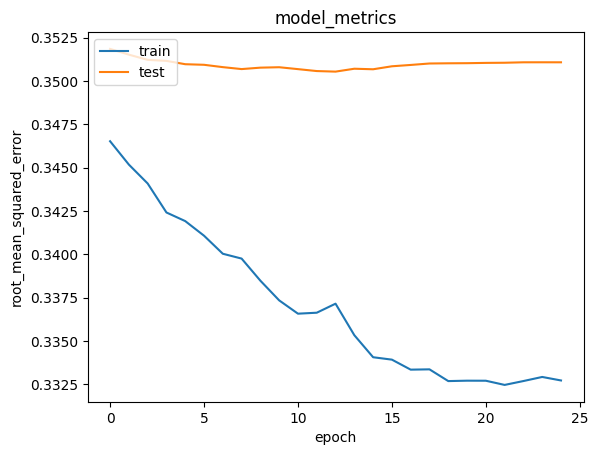

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Dari grafik yang dihasilkan:
* **Kurva RMSE Pelatihan (Garis Biru):** Menunjukkan penurunan nilai RMSE seiring bertambahnya epoch. Ini mengindikasikan bahwa model berhasil mempelajari pola dari data pelatihan, dan kesalahannya dalam memprediksi rating pada data yang sudah dilihatnya semakin mengecil.
* **Kurva RMSE Validasi (Garis Oranye):** Memperlihatkan bagaimana model bergeneralisasi pada data yang belum pernah dilihat sebelumnya. Pada grafik ini, terlihat bahwa RMSE validasi awalnya menurun (atau sedikit naik) lalu cenderung stagnan bahkan sedikit meningkat, sementara RMSE pelatihan terus menurun. Kesenjangan (gap) antara kurva pelatihan dan validasi, terutama jika RMSE validasi mulai meningkat, bisa menjadi indikasi *overfitting*, di mana model terlalu spesifik pada data pelatihan dan kurang baik dalam generalisasi. Stagnasi RMSE validasi menunjukkan batas kemampuan model untuk belajar lebih lanjut dari data yang ada dengan konfigurasi saat ini.

Observasi ini penting untuk memahami dinamika pelatihan dan memutuskan strategi lebih lanjut, seperti penggunaan *early stopping* (yang tampaknya sudah diimplementasikan berdasarkan kode sebelumnya) atau penyesuaian arsitektur model dan regularisasi.

### Perhitungan RMSE dan MAE pada Data Validasi

Setelah model selesai dilatih (atau dihentikan oleh *early stopping* dengan bobot terbaik), sel ini bertujuan untuk mengevaluasi performa akhir model dalam memprediksi rating pada data validasi (`x_val`, `y_val`) yang belum pernah dilihatnya selama proses pelatihan. Dua metrik utama yang digunakan di sini adalah Root Mean Squared Error (RMSE) dan Mean Absolute Error (MAE), yang dihitung pada rating yang telah dinormalisasi (skala 0 hingga 1).

1.  **Mean Absolute Error (MAE)**: Metrik ini mengukur rata-rata selisih absolut antara rating aktual dan rating prediksi. Formulanya adalah:
$$MAE = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|$$
  MAE memberikan gambaran langsung tentang seberapa besar rata-rata kesalahan prediksi model tanpa mempedulikan arah kesalahan (apakah prediksi lebih tinggi atau lebih rendah dari aktual). Nilai MAE yang lebih kecil lebih baik.

2.  **Root Mean Squared Error (RMSE)**: Seperti yang telah dijelaskan sebelumnya, RMSE juga mengukur rata-rata kesalahan prediksi namun memberikan penalti lebih besar untuk kesalahan yang lebih besar.

In [ ]:
y_pred = model.predict(x_val).flatten()

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae  =     mean_absolute_error(y_val, y_pred)

print(f"⏱️ Evaluasi Prediksi Rating pada Data Validasi:")
print(f"    • RMSE: {rmse:.4f}")
print(f"    • MAE : {mae:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
⏱️ Evaluasi Prediksi Rating pada Data Validasi:
    • RMSE: 0.3498
    • MAE : 0.3012


Berdasarkan output yang ditampilkan:
* **RMSE: 0.3498**
* **MAE: 0.3012**

Nilai-nilai ini (pada skala rating ternormalisasi 0-1) memberikan ukuran kuantitatif seberapa dekat prediksi rating model dengan rating aktual yang diberikan oleh pengguna pada data validasi. RMSE sebesar 0.3498 menunjukkan bahwa, secara rata-rata dengan penalti pada error besar, prediksi model memiliki simpangan sekitar nilai tersebut dari rating aktual ternormalisasi. Sementara itu, MAE sebesar 0.3012 mengindikasikan bahwa rata-rata selisih absolut prediksi dari nilai sebenarnya adalah sekitar 0.3012 pada skala 0-1. Untuk interpretasi yang lebih intuitif terkait skala rating asli (misalnya 1-5), nilai ini perlu dikembalikan ke skala tersebut. Namun, sebagai perbandingan antar model atau konfigurasi, metrik pada skala ternormalisasi ini sudah cukup informatif. Semakin rendah kedua nilai ini, semakin akurat model dalam memprediksi rating.

### Evaluasi Model Menggunakan Precision@K, Recall@K, dan F1-Score@K

Selain akurasi prediksi rating, penting juga untuk mengevaluasi seberapa baik model *collaborative filtering* ini dalam menghasilkan daftar rekomendasi item yang relevan untuk pengguna. Pada sel ini, kita melakukan evaluasi performa *top-N recommendation*, spesifiknya untuk **Top-10 rekomendasi (K=10)**.

Karena output model adalah prediksi rating kontinu (yang telah dinormalisasi antara 0 dan 1), langkah pertama adalah menentukan item mana yang dianggap "relevan" berdasarkan rating aktual pengguna. Kita menetapkan **ambang batas relevansi (`RELEVANT_THRESHOLD`)**. Dalam konteks proyek ini, disebutkan bahwa threshold 0.50 (pada skala ternormalisasi) dipilih, yang setara dengan rating asli 3 (pada skala 1-5). Item di data validasi yang memiliki rating aktual (`true_rating`) sama dengan atau lebih besar dari threshold ini dikategorikan sebagai item relevan. Pilihan rating 3 sebagai batas relevansi didasarkan pada analisis distribusi data rating yang menunjukkan mean dan median berada di sekitar angka tersebut, mengindikasikan bahwa rating 3 ke atas dapat dianggap sebagai preferensi positif pengguna.

Langkah-langkah evaluasi yang dilakukan adalah sebagai berikut:
1.  Model memprediksi rating untuk semua pasangan pengguna-item dalam data validasi.
2.  Untuk setiap pengguna, 10 item dengan prediksi rating tertinggi (`pred_rating`) dipilih sebagai rekomendasi (Top-10).
3.  Kemudian, untuk setiap pengguna, kita membandingkan 10 item yang direkomendasikan ini dengan daftar item yang *sebenarnya* relevan bagi mereka (berdasarkan `RELEVANT_THRESHOLD` pada `true_rating`).

Dari perbandingan ini, kita menghitung tiga metrik utama yang dirata-ratakan untuk semua pengguna:

* **Precision@K**: Mengukur proporsi item yang direkomendasikan dalam K item teratas yang benar-benar relevan.
  $$Precision@K = \frac{\text{Jumlah item relevan dalam K rekomendasi}}{\text{K}}$$
    Dalam konteks ini (K=10), Precision@10 menunjukkan seberapa banyak dari 10 destinasi yang direkomendasikan benar-benar merupakan destinasi yang (berdasarkan data historis) kemungkinan besar disukai pengguna.

* **Recall@K**: Mengukur proporsi item relevan yang berhasil ditemukan dan direkomendasikan oleh model, dari keseluruhan item yang sebenarnya relevan bagi pengguna.
  $$Recall@K = \frac{\text{Jumlah item relevan dalam K rekomendasi}}{\text{Total item relevan untuk pengguna di data validasi}}$$
    Recall@10 mengindikasikan seberapa banyak destinasi yang disukai pengguna berhasil "ditangkap" atau dimunculkan dalam daftar 10 rekomendasi teratas.

* **F1-Score@K**: Merupakan rata-rata harmonik dari Precision@K dan Recall@K, memberikan ukuran tunggal yang menyeimbangkan kedua metrik tersebut.
  $$F1-Score@K = 2 \cdot \frac{Precision@K \cdot Recall@K}{Precision@K + Recall@K}$$
    F1-Score berguna karena terkadang ada *trade-off* antara Precision (ingin rekomendasi seakurat mungkin) dan Recall (ingin menemukan semua item relevan).

Setelah kode pada sel ini dijalankan, outputnya akan menampilkan nilai rata-rata dari F1-Score@10, Precision@10, dan Recall@10.

Secara keseluruhan, hasil evaluasi ini menunjukkan bahwa model *collaborative filtering* yang dikembangkan memiliki performa yang menjanjikan, terutama dalam hal memastikan pengguna tidak kehilangan banyak destinasi yang mungkin mereka sukai (Recall tinggi). Upaya di masa depan dapat difokuskan pada peningkatan presisi, misalnya dengan menyesuaikan ambang batas, menyempurnakan fitur, atau mencoba teknik pemeringkatan yang lebih canggih, untuk lebih lanjut meningkatkan relevansi dari item-item yang berada di posisi teratas rekomendasi tanpa mengorbankan cakupan yang sudah baik.

In [ ]:
# Ambang batas rating untuk dianggap relevan
RELEVANT_THRESHOLD = (3 - min_rating) / (max_rating - min_rating)  # karena rating dinormalisasi 0–1, threshold 0.75 ≈ rating 4 dari 5
K = 10  # Top-K rekomendasi

# Prediksi rating
y_pred = model.predict(x_val).flatten()

# Gabungkan prediksi dengan data validasi
val_df = pd.DataFrame(x_val, columns=['user_encoded', 'place_encoded'])
val_df['pred_rating'] = y_pred
val_df['true_rating'] = y_val

# Ubah label rating jadi relevan/tidak relevan
val_df['is_relevant'] = val_df['true_rating'] >= RELEVANT_THRESHOLD

# Simpan top-K prediksi per user
top_k_recommendations = (
    val_df.sort_values(by=['user_encoded', 'pred_rating'], ascending=[True, False])
    .groupby('user_encoded')
    .head(K)
)

# Hitung Precision@K dan Recall@K per user
precision_list = []
recall_list = []

for user_id, group in top_k_recommendations.groupby('user_encoded'):
    true_positives = group['is_relevant'].sum()

    # Total relevan item untuk user ini dalam seluruh validasi
    total_relevant = val_df[(val_df['user_encoded'] == user_id) & (val_df['is_relevant'])].shape[0]

    precision = true_positives / K
    recall = true_positives / total_relevant if total_relevant > 0 else 0

    precision_list.append(precision)
    recall_list.append(recall)

# Hasil rata-rata
avg_precision_at_k = np.mean(precision_list)
avg_recall_at_k = np.mean(recall_list)
if (avg_precision_at_k + avg_recall_at_k) > 0:
    avg_f1_at_k = 2 * (avg_precision_at_k * avg_recall_at_k) / (avg_precision_at_k + avg_recall_at_k)
else:
    avg_f1_at_k = 0.0

print(f"F1-Score@{K}: {avg_f1_at_k:.4f}")
print(f"Precision@{K}: {avg_precision_at_k:.4f}")
print(f"Recall@{K}: {avg_recall_at_k:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
F1-Score@10: 0.5703
Precision@10: 0.4044
Recall@10: 0.9673


Berdasarkan hasil perhitungan metrik evaluasi Top-N dari sel sebelumnya, kita mendapatkan:
* **Recall@10: 0.9673**
* **Precision@10: 0.4044**
* **F1-Score@10: 0.5703**

Berikut adalah interpretasi dari hasil tersebut dalam konteks performa model rekomendasi destinasi wisata ini:

- **Recall@10 sebesar 0.9673** menunjukkan bahwa model berhasil menemukan sekitar 96.82% dari item (destinasi) yang dianggap relevan atau disukai pengguna (berdasarkan ambang batas rating yang ditetapkan) di antara seluruh item relevan yang ada untuk pengguna tersebut di data validasi. Ini merupakan hasil yang sangat baik dan mengindikasikan bahwa model memiliki cakupan rekomendasi yang luas; artinya, model sangat efektif dalam "mengingat" dan menyajikan kembali sebagian besar destinasi yang kemungkinan besar akan disukai oleh pengguna. Pengguna kemungkinan besar tidak akan melewatkan banyak destinasi favorit mereka yang potensial dari rekomendasi yang diberikan.

- **Precision@10 sebesar 0.4044** berarti bahwa dari 10 destinasi teratas yang direkomendasikan kepada pengguna, rata-rata sekitar 40.5% (atau sekitar 4 dari 10) di antaranya adalah destinasi yang benar-benar relevan atau disukai pengguna. Meskipun idealnya kita menginginkan nilai presisi yang lebih tinggi, nilai ini menunjukkan bahwa model sudah memiliki kemampuan yang cukup baik dalam memprioritaskan item-item yang relevan untuk muncul di posisi atas daftar rekomendasi. Ada ruang untuk peningkatan agar rekomendasi yang disajikan menjadi lebih "tepat sasaran", mengurangi jumlah destinasi yang kurang relevan dalam 10 teratas.

- **F1-Score@10 sebesar 0.5703** merupakan rata-rata harmonik yang menyeimbangkan antara Precision@10 dan Recall@10. Nilai ini memberikan ukuran performa tunggal yang mempertimbangkan baik kemampuan model untuk menemukan kembali item relevan (Recall) maupun ketepatan dari item yang direkomendasikan tersebut (Precision). F1-Score sebesar 0.5703, dalam kasus ini, sangat dipengaruhi oleh Recall yang tinggi. Ini menandakan bahwa meskipun model sangat kuat dalam hal cakupan (menemukan hampir semua item yang relevan), keseimbangan keseluruhannya sedikit terpengaruh oleh presisi yang lebih moderat. Model ini cenderung lebih inklusif (memasukkan banyak item relevan) dengan risiko beberapa item yang direkomendasikan mungkin kurang relevan, daripada menjadi sangat eksklusif (hanya merekomendasikan item yang sangat pasti relevan tapi mungkin melewatkan beberapa).